In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.decomposition import PCA

f:\code\kaggle\birdclef-2023\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
f:\code\kaggle\birdclef-2023\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable


def get_spark(cores=4, memory="2g"):
    """Get a spark session for a single driver."""
    return (
        SparkSession.builder.config("spark.driver.memory", memory)
        .config("spark.driver.cores", cores)
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )


spark = get_spark()

In [4]:
url = "https://storage.googleapis.com/birdclef-2023/data/processed/2022-01-15-assessment.parquet"
df = pd.read_parquet(url)
df.head()

,id,filename,start_sec,end_sec,confidence,birdnet_label,birdnet_common_name,emb,primary_label,secondary_labels,type,neighbors,distances
0,1,houspa/XC121738.ogg,51.0,54.0,0.7677,eutspa,Eurasian Tree Sparrow,"[1.4410583, 1.5985851, 1.1828262, 0.55653006, ...",houspa,[],['call'],"[0, 57, 292, 24, 27, 269, 199, 445, 111, 196, ...","[0.0, 7.545195579528809, 7.966801643371582, 8...."
1,2,houspa/XC124181.ogg,0.0,3.0,0.9652,houspa,House Sparrow,"[2.0463464, 1.2236276, 0.70286447, 1.3113645, ...",houspa,[],['call'],"[1, 237, 244, 255, 83, 264, 198, 240, 31, 322,...","[0.0, 5.581757068634033, 6.375831604003906, 6...."
2,3,houspa/XC131300.ogg,18.0,21.0,0.8707,eutspa,Eurasian Tree Sparrow,"[1.5261635, 1.939797, 1.4180027, 0.9176945, 1....",houspa,[],"['call', 'male', 'song']","[2, 441, 263, 401, 269, 323, 304, 31, 46, 192,...","[0.0, 7.3610758781433105, 7.4461188316345215, ..."
3,4,houspa/XC133262.ogg,48.0,51.0,0.8861,whcspa,White-crowned Sparrow,"[0.7386549, 1.3903569, 1.2590201, 1.2009335, 0...",houspa,[],"['begging call', 'juvenile']","[3, 1127, 528, 1102, 79, 1155, 1208, 642, 21, ...","[0.0, 8.889424324035645, 9.17027759552002, 9.2..."
4,5,houspa/XC139186.ogg,0.0,3.0,0.7380,houspa,House Sparrow,"[1.0389303, 1.9639286, 0.81923, 1.1145979, 1.2...",houspa,[],"['male', 'song']","[4, 269, 305, 82, 346, 150, 192, 460, 367, 149...","[0.0, 5.821669101715088, 5.945547580718994, 5...."


In [5]:
spark_df = spark.createDataFrame(df)
spark_df.printSchema()
spark_df.show(n=1, vertical=True, truncate=80)

root
 |-- id: integer (nullable = true)
 |-- filename: string (nullable = true)
 |-- start_sec: double (nullable = true)
 |-- end_sec: double (nullable = true)
 |-- confidence: double (nullable = true)
 |-- birdnet_label: string (nullable = true)
 |-- birdnet_common_name: string (nullable = true)
 |-- emb: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- primary_label: string (nullable = true)
 |-- secondary_labels: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbors: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- distances: array (nullable = true)
 |    |-- element: double (containsNull = true)

-RECORD 0-----------------------------------------------------------------------------------------------
 id                  | 1                                                                                
 filename            | houspa/XC121738.ogg                                                              
 s

## 1. plotting embedding points

UMAP( verbose=True)
Mon Jan 16 00:33:30 2023 Construct fuzzy simplicial set
Mon Jan 16 00:33:31 2023 Finding Nearest Neighbors
Mon Jan 16 00:33:32 2023 Finished Nearest Neighbor Search
Mon Jan 16 00:33:34 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:02]


Mon Jan 16 00:33:36 2023 Finished embedding


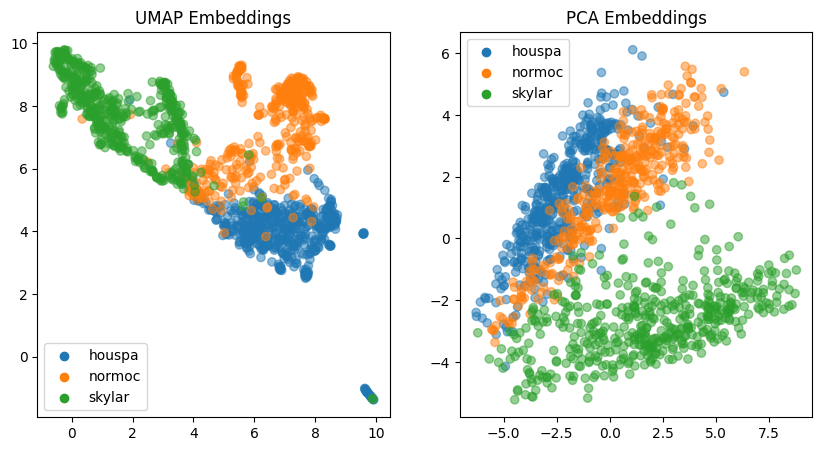

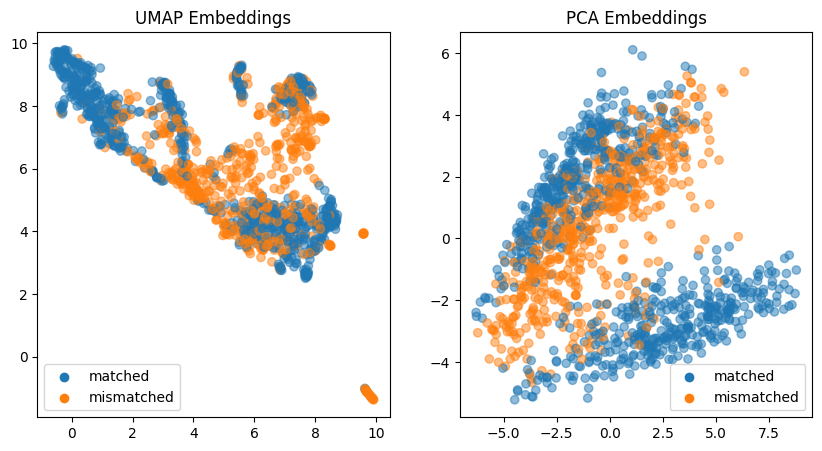

In [6]:
# plot the embeddings

X = np.stack(df.emb)
emb_umap = UMAP(n_components=2, verbose=True).fit_transform(X)
emb_pca = PCA(n_components=2).fit_transform(X)

primary_label = df.primary_label
birdnet_label = df.birdnet_label

embs = {"UMAP": emb_umap, "PCA": emb_pca}

# 2x1 plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_map = {color: f"C{i}" for i, color in enumerate(primary_label.unique())}

for i, (name, emb) in enumerate(embs.items()):
    ax = axes[i]
    ax.scatter(emb[:, 0], emb[:, 1], alpha=0.5, c=primary_label.apply(color_map.get))
    ax.set_title(f"{name} Embeddings")
    # labels for the colors
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label=label)
    ax.legend()
plt.show()


# 2x1 plot, but labeling whether the primary and birdnet labels match
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
color_map = {True: "C0", False: "C1"}
for i, (name, emb) in enumerate(embs.items()):
    ax = axes[i]
    ax.scatter(
        emb[:, 0],
        emb[:, 1],
        alpha=0.5,
        c=primary_label.eq(birdnet_label).apply(color_map.get),
    )
    ax.set_title(f"{name} Embeddings")
    # labels for the colors
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label="matched" if label else "mismatched")
    ax.legend()

## 2. k-nn classification

### (a) How would you compute the nearest neighbors of all points in the dataset?

What distance metric would you use? What algorithms or libraries would you use? What is the computational complexity of your algorithm? No code is required for the question; a short answer will suffice.

### (b) What percentage of primary labels are correctly predicted by BirdNET for each species?

For this question, you must answer using PySpark SQL (mostly-compliant ANSI SQL dialect) or the PySpark Dataframe API.
See the [Spark SQL reference](https://spark.apache.org/docs/3.2.0/sql-ref.html) and [API docs](https://spark.apache.org/docs/3.1.2/api/python/reference/pyspark.sql.html) for more information.

Hint: common table expressions (CTEs) are useful for organizing queries, and for reusing subqueries.

In [7]:
labels = spark_df.select("id", "primary_label", "birdnet_label")
labels.createOrReplaceTempView("labels")
labels.printSchema()

# NOTE: example of using the sql interface to spark
spark.sql(
    """
    SELECT
        primary_label,
        count(*) as n
    FROM labels
    GROUP BY 1
    ORDER BY n DESC
    """
).show()

# NOTE: the same query, but using the dataframe interface
labels.groupBy("primary_label").agg(F.count("*").alias("n")).orderBy(F.desc("n")).show()

root
 |-- id: integer (nullable = true)
 |-- primary_label: string (nullable = true)
 |-- birdnet_label: string (nullable = true)

+-------------+---+
|primary_label|  n|
+-------------+---+
|       houspa|497|
|       skylar|491|
|       normoc|381|
+-------------+---+

+-------------+---+
|primary_label|  n|
+-------------+---+
|       houspa|497|
|       skylar|491|
|       normoc|381|
+-------------+---+



In [8]:
spark.sql(
    """
    with totals as (
        select 
            primary_label, 
            count(*) as n
        from labels
        group by 1
    ),
    matched as (
        select
            primary_label,
            count(*) as n
        from labels
        where primary_label = birdnet_label
        group by 1
    )
    select
        primary_label,
        matched.n / totals.n * 100 as pct
    from matched
    join totals using (primary_label)
    order by pct desc
    """
).show()

+-------------+------------------+
|primary_label|               pct|
+-------------+------------------+
|       skylar| 75.35641547861506|
|       houspa| 64.38631790744466|
|       normoc|27.821522309711288|
+-------------+------------------+



### (c) Compute labels for each point in the dataset using k-nn classification.

For each id, find the most common label among it's using the `mode` of the BirdNET labels.
Run the `compute_pct` function to compute the percentage of "correct" predictions.
How does this answer compare to the answer in (b)?

For this question, you must answer using PySpark SQL (mostly-compliant ANSI SQL dialect) or the PySpark Dataframe API.
See the [Spark SQL reference](https://spark.apache.org/docs/3.2.0/sql-ref.html) and [API docs](https://spark.apache.org/docs/3.1.2/api/python/reference/pyspark.sql.html) for more information.


In [9]:
neighbors = spark_df.select(
    "id", F.posexplode("neighbors").alias("pos", "neighbor_id")
).orderBy("id", "pos")
neighbors.createOrReplaceTempView("neighbors")
neighbors.printSchema()

# NOTE: example of using the neighbors table with the labels table
spark.sql(
    """
    SELECT
        neighbors.id,
        pos,
        neighbor_id,
        primary_label
    FROM neighbors
    JOIN labels ON neighbors.neighbor_id = labels.id
    LIMIT 5
"""
).show()

# NOTE: example of using the neighbors table with the labels table
neighbors.join(labels.withColumnRenamed("id", "neighbor_id"), on="neighbor_id").select(
    "id", "pos", "neighbor_id", "primary_label"
).limit(5).show()

root
 |-- id: integer (nullable = true)
 |-- pos: integer (nullable = false)
 |-- neighbor_id: long (nullable = true)

+---+---+-----------+-------------+
| id|pos|neighbor_id|primary_label|
+---+---+-----------+-------------+
|138|  6|         26|       houspa|
|118| 19|         26|       houspa|
| 77| 19|         26|       houspa|
| 27|  0|         26|       houspa|
|248|  8|         29|       houspa|
+---+---+-----------+-------------+

+---+---+-----------+-------------+
| id|pos|neighbor_id|primary_label|
+---+---+-----------+-------------+
|138|  6|         26|       houspa|
|118| 19|         26|       houspa|
| 77| 19|         26|       houspa|
| 27|  0|         26|       houspa|
|248|  8|         29|       houspa|
+---+---+-----------+-------------+



In [10]:
knn_result = spark.sql(
    """
    with labeled_neighbors as (
        select
            neighbors.id,
            neighbor_id,
            birdnet_label
        from neighbors
        join labels on neighbors.neighbor_id = labels.id
    ),
    -- neighbor labels
    neighbor_mode as (
        select
            id,
            birdnet_label,
            count(*) as n
        from labeled_neighbors
        group by 1, 2
    ),
    -- most common neighbor label
    neighbor_mode_max as (
        select
            id,
            birdnet_label,
            row_number() over (partition by id order by n desc) as rank
        from neighbor_mode
    ),
    -- per species count
    bird_net_counts as (
        select
            t1.id,
            t1.birdnet_label
        from neighbor_mode_max t1
        join labels using (id)
        where rank = 1
    )
    select * from bird_net_counts
    """
)
assert knn_result.columns == ["id", "birdnet_label"], "mismatched columns"
assert knn_result.count() == labels.count(), "mismatched row counts"
knn_result.groupBy("birdnet_label").count().show()

+-------------+-----+
|birdnet_label|count|
+-------------+-----+
|       logshr|    2|
|       pyrrhu|    2|
|       houspa|  593|
|       blujay|    1|
|       crithr|    9|
|       skylar|  552|
|       cubthr|    8|
|       normoc|  202|
+-------------+-----+



In [11]:
knn_result.createOrReplaceTempView("knn")
spark.sql(
    """
    with totals as (
        select 
            primary_label, 
            count(*) as n
        from labels
        group by 1
    ),
    matched as (
        select
            primary_label,
            count(*) as n
        from knn
        join labels using (id)
        where primary_label = knn.birdnet_label
        group by 1
    )
    select
        primary_label,
        matched.n / totals.n * 100 as pct
    from matched
    join totals using (primary_label)
    order by pct desc
    """
).show()

+-------------+------------------+
|primary_label|               pct|
+-------------+------------------+
|       skylar| 98.57433808553971|
|       houspa| 98.18913480885311|
|       normoc|53.018372703412076|
+-------------+------------------+



In [12]:
# NOTE: to avoid spoiling part (b), we compute percentages in python/pandas
def compute_pct(knn_result, labels):
    temp_knn_df = knn_result.toPandas()
    temp_labels_df = labels.select("id", "primary_label").toPandas()

    joined = temp_knn_df.merge(temp_labels_df, on="id")

    counts = {}
    for label in temp_labels_df.primary_label.unique():
        sub = joined[joined.primary_label == label]
        a = sub[sub.birdnet_label == label].shape[0]
        b = sub.shape[0]
        counts[label] = a / b * 100

    spark.createDataFrame(
        [(k, float(v)) for k, v in counts.items()], ["label", "pct"]
    ).show()


compute_pct(knn_result, labels)

+------+------------------+
| label|               pct|
+------+------------------+
|houspa| 98.18913480885311|
|normoc|53.018372703412076|
|skylar| 98.57433808553971|
+------+------------------+



## 3. transfer learning

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

subset = df[df.primary_label.isin(["normoc", "skylar"])]
X = np.stack(subset.emb)
y = subset.primary_label.eq("normoc").astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y)

### (a) Fit BirdNET embeddings to a logistic regression model

In [14]:
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
score = clf.score(X_test, y_test)
print(f"Accuracy: {score:.2%}")

Accuracy: 98.62%


### (b) Fit BirdNET embeddings to a non-linear neural network model

In [15]:
class Net(nn.Module):
    def __init__(self, input_dim=320, hidden_dim=64):
        super().__init__()
        # 3 layers, input, hidden, output
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [16]:
def train_generator(
    net: Net,
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 100,
    criterion=nn.BCELoss(),
    lr: float = 0.001,
):
    """A python generator that yields the epoch and loss at each step."""
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(torch.from_numpy(X_train).float())
        loss = criterion(
            outputs, torch.from_numpy(y_train.values.reshape(-1, 1)).float()
        )
        loss.backward()
        optimizer.step()
        yield epoch, loss.item()

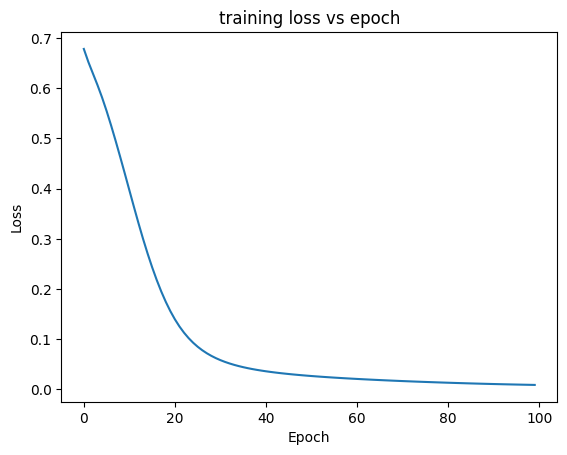

0.9954128440366973

In [17]:
net = Net(input_dim=X_train.shape[1])

values = list(train_generator(net, X_train, y_train))
epochs, losses = zip(*values)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("training loss vs epoch")
plt.show()

predicted = net(torch.from_numpy(X_test).float())
accuracy_score(predicted.detach().numpy().reshape(-1) > 0.5, y_test)

### (c) Analyze the input data in the embedding space of the second-to-last layer of the model defined in part (b)

In [18]:
# https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activations = {}


def get_activation(name):
    """Register a hook to extract activations from a layer."""

    def hook(model, input, output):
        activations[name] = output.detach().numpy()

    return hook


net.fc2.register_forward_hook(get_activation("fc2"))
_ = net(torch.from_numpy(X).float())

(872, 64)


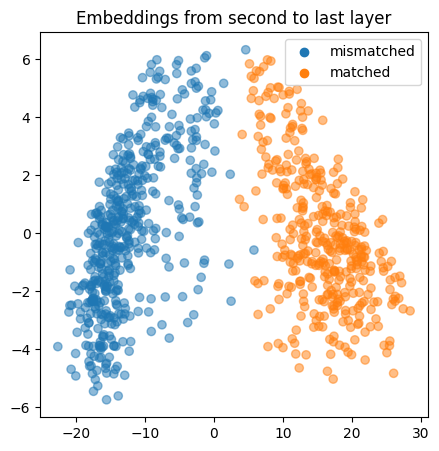

In [19]:
def plot_fc(emb, colors):
    # plot the data
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    color_map = {0: "C0", 1: "C1"}
    ax.scatter(emb[:, 0], emb[:, 1], alpha=0.5, c=[color_map[c] for c in colors])
    for label, color in color_map.items():
        ax.scatter([], [], c=color, label="matched" if label else "mismatched")
    ax.set_title(f"Embeddings from second to last layer")
    plt.legend()
    plt.plot()


fc2 = activations["fc2"]
print(fc2.shape)
plot_fc(PCA(n_components=2).fit_transform(fc2), y)